<a href="https://colab.research.google.com/github/Kulikov17/MLDS_RecSys/blob/main/RecSys_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание: рекомендательные системы

В этом домашнем задании будем работать с данными о пользователях и оценках, которые они поставили различным фильмам.

На основе этих данных будем рекомендовать пользователям к просмотру новые для них фильмы.

* За решение всех пунктов из домашнего задания можно получить 11 баллов максимум.
* В ведомость курса ставится балл, равный **min(ваш набранный балл, 10)**.

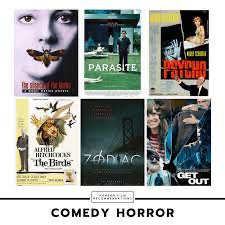

В домашней работе вы примените как базовые методы для построения рекомендаций, так и Deep Learning подходы.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from typing import List, Dict
from tqdm import tqdm, tqdm_notebook

## 0. Загрузка и обработка данных

Загрузим данные.

In [29]:
ratings = pd.read_csv('https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/movies_ratings.csv')

In [30]:
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

ratings['userId'] = user_encoder.fit_transform(ratings['userId'])
ratings['movieId'] = item_encoder.fit_transform(ratings['movieId'])

num_users, num_movies = ratings.userId.nunique(), ratings.movieId.nunique()
num_users, num_movies

(671, 9025)

Поделим выборку на train и test так, чтобы у каждого пользователя последние 10 фильмов оказались в тесте для подсчета метрики качества рекомендаций k=10.  

In [31]:
train, test = [], []
num_test_samples = 10

for user, data in ratings.groupby('userId'):
    train += [data[:-num_test_samples]]
    test += [data[-num_test_samples:]]

train = pd.concat(train)
test = pd.concat(test)
print(train.shape, test.shape)

(93140, 5) (6710, 5)


In [32]:
train.head()

,userId,movieId,rating,timestamp,title
0,0,30,2.5,1260759144,Dangerous Minds
42,0,830,3.0,1260759179,Dumbo
84,0,856,3.0,1260759182,Sleepers
117,0,903,2.0,1260759185,Escape from New York
165,0,927,4.0,1260759205,Cinema Paradiso


Запишите данные в формате, где строка соответствует пользователю, а столбцы будут истинными метками и предсказаниями в виде списков.

Назовите полученную таблицу `interactions`, действуйте по аналогии или воспользуйтесь [кодом из семинара по ML](https://github.com/Murcha1990/MLDS_ML_2022/blob/main/Занятие_13_Recsys1/MLHS_Recsys_1.ipynb).

In [33]:
interactions = (
    train
    .groupby('userId')['movieId'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'movieId': 'true_train'})
    .set_index('userId')
)

interactions['true_test'] = (
    test
    .groupby('userId')['movieId'].agg(lambda x: list(x))
)

# заполнение пропусков пустыми списками
interactions.loc[pd.isnull(interactions.true_test), 'true_test'] = [
    [''] for x in range(len(interactions.loc[pd.isnull(interactions.true_test), 'true_test']))]

interactions.head(5)

,true_train,true_test
userId,,
0,"[30, 830, 856, 903, 927, 1013, 1037, 1043, 107...","[1107, 1136, 1511, 1661, 1704, 1739, 1811, 195..."
1,"[9, 16, 37, 45, 48, 49, 58, 100, 123, 129, 132...","[518, 519, 520, 521, 522, 523, 524, 525, 543, ..."
2,"[100, 266, 321, 341, 472, 521, 524, 525, 56, 2...","[5008, 5107, 5456, 5461, 5874, 6345, 6518, 656..."
3,"[1107, 1511, 1661, 1739, 2375, 9, 132, 163, 26...","[2491, 2495, 2543, 2575, 2576, 2602, 2606, 261..."
4,"[1811, 37, 129, 321, 328, 331, 341, 447, 519, ...","[5955, 5957, 6098, 6118, 6144, 6172, 6260, 627..."


Для оценки качества модели будем использовать метрику  precision@10 для каждого пользователя (доля угаданных рекомендаций). Усредним ее по всем пользователям (полученная метрика называется MAP@10).

In [34]:
def calc_precision(column):
    return (
        interactions
        .apply(
            lambda row:
            len(set(row['true_test']).intersection(
                set(row[column]))) /
            min(len(row['true_test']) + 0.001, 10.0),
            axis=1)).mean()

# 1. Коллаборативная фильтрация (2 балла)

Составьте матрицу "оценок" пользователей - `ratings`. Нули будут обозначать отсутствие взаимодействия **(0.25 балла)**.

Действуйте по аналогии или воспользуйтесь кодом из семинара по ML (ссылка выше).

In [7]:
ratings = pd.pivot_table(
    train,
    values='rating',
    index='userId',
    columns='movieId').fillna(0)

In [9]:
ratings_m = ratings.values

Посчитайте схожести пользователей (запишите их в np.array `similarity_users`) с помощью корреляции Пирсона. Для каждой пары учитывайте только ненулевые значения **(0.5 балла)**.

Действуйте по аналогии или воспользуйтесь кодом из семинара по ML.

In [10]:
similarity_users = np.zeros((len(ratings_m), len(ratings_m)))

for i in tqdm_notebook(range(len(ratings_m) - 1)):
    for j in range(i + 1, len(ratings_m)):

        # nonzero elements of two users
        mask_uv = (ratings_m[i] != 0) & (ratings_m[j] != 0)

        # continue if no intersection
        if np.sum(mask_uv) == 0:
            continue

        # get nonzero elements
        ratings_v = ratings_m[i, mask_uv]
        ratings_u = ratings_m[j, mask_uv]

        # for nonzero std
        if len(np.unique(ratings_v)) < 2 or len(np.unique(ratings_u)) < 2:
            continue

        similarity_users[i,j] = np.corrcoef(ratings_v, ratings_u)[0, 1]
        similarity_users[j,i] = similarity_users[i,j]

  0%|          | 0/670 [00:00<?, ?it/s]

Сделайте user-based прогнозы по тому же правилу, что и в семинаре по ML **(1 балл)**:

Для каждого пользователя:

1. Найдём пользователей с похожестью больше $\alpha$ на нашего пользователя.
2. Посчитаем для каждого фильма долю пользователей (среди выделенных на первом шаге), которые взаимодействовали с этим фильмом.
3. Порекомендуем фильмы с наибольшими долями со второго шага (среди тех, которые пользователь ещё не видел).

В нашем примере данных не очень много, поэтому возьмём $\alpha = 0$.

Сделайте предсказания и запишите их в столбец
`prediction_user_based` таблицы `interactions`.

In [11]:
prediction_user_based = []

for i in tqdm_notebook(range(len(similarity_users))):

    users_sim = similarity_users[i] > 0

    if len(users_sim) == 0:
        prediction_user_based.append([])
    else:
        tmp_recommend = np.argsort(ratings_m[users_sim].sum(axis=0))[::-1]
        tmp_recommend = ratings.columns[tmp_recommend]
        recommend = np.array(tmp_recommend)[~np.in1d(tmp_recommend, interactions.iloc[i])][:10]
        prediction_user_based.append(list(recommend))

interactions['prediction_user_based'] = prediction_user_based

  0%|          | 0/671 [00:00<?, ?it/s]

Посчитайте значение метрики MAP@10 для user-based подхода **(0.25 балла)**.

In [12]:
calc_precision('prediction_user_based')

0.005365126676602086

## 2. SVD-разложение (2 балла)

Для выполнения заданий при необходимости заглядывайте в ноутбук из семинара по ML.

Сделайте сингулярное разложение (svd в scipy.linalg), на выходе вы получите три матрицы - `U`,`sigma`,`V` **(0.5 балла)**.

In [11]:
from scipy.linalg import svd

In [14]:
U, sigma, V = svd(ratings)

print(ratings.shape, U.shape, sigma.shape, V.shape)

(671, 8044) (671, 671) (671,) (8044, 8044)


In [15]:
Sigma = np.zeros((671, 8044))
Sigma[:671, :671] = np.diag(sigma)

new_ratings = U.dot(Sigma).dot(V)

print(sum(sum((new_ratings - ratings.values) ** 2)))

1.958908631331984e-23


Значения у матрицы с сингулярными числами отсортированы по убыванию.

Оставьте только первые 150 компонент, чтобы получить скрытые представления размерности 150 **(0.5 балла)**.

Для этого необходимо оставить 150 столбцов в матрице U, оставить из sigma только первые 150 значений (и сделать из них диагональную матрицу) и 150 столбцов в матрице V. Перемножим преобразованные матрицы ($\hat{U}, \hat{sigma}, \hat{V^T}$), чтобы получить восстановленную матрицу оценок.

In [16]:
K = 150

U = U[:, :K]
V = V[:K, :]
Sigma = np.diag(sigma[:K])

Посчитайте качество аппроксимации матрицы по норме Фробениуса (среднеквадратичную ошибку между всеми элементами соответствующими элементами двух матриц). Сравните его с простым бейзлайном с константным значением, равным среднему значению исходной матрицы. У аппроксимации ошибка должна получиться ниже **(0.25 балла)**.

In [17]:
new_ratings = U.dot(Sigma).dot(V)

print(sum(sum((new_ratings - ratings.values) ** 2)))
print(sum(sum((ratings.values.mean() - ratings.values) ** 2)))

248017.78364373557

1255671.6721978304


Теперь сделайте предсказания по матрице (не забывайте про то, что уже было просмотрено пользователем) **(0.5 балла)**.

Для этого необходимо для каждого пользователя найти предметы с наибольшими оценками в восстановленной матрице.

In [18]:
new_ratings = pd.DataFrame(new_ratings, index=ratings.index, columns=ratings.columns)

In [21]:
num_test_samples

10

In [19]:
new_ratings = pd.DataFrame(new_ratings, index=ratings.index, columns=ratings.columns)

predictions = []

for userId in tqdm_notebook(interactions.index):
    prediction = (
        new_ratings
        .loc[userId]
        .sort_values(ascending=False)
        .index.values
    )

    predictions.append(
        list(prediction[~np.in1d(
            prediction,
            interactions.loc[userId, 'true_train'])])[:num_test_samples])

interactions['prediction_svd'] = predictions

  0%|          | 0/671 [00:00<?, ?it/s]

Посчитайте значение метрики MAP@10 для SVD-подхода **(0.25 балла)**.

In [20]:
calc_precision('prediction_svd')

0.022652757078986587

# 3. Градиентный Бустинг / Библиотека CatBoost (1.5 балла)

В задаче рекомендаций так же можно использовать метод градиентного бустинга. Мы будем использовать библиотеку `CatBoost`. Для предсказаний мы будем использовать векторы после SVD разложения, которые будут показывать информацию о пользователе или фильме. На выход у нас будет оценка пользователя фильма.

In [ ]:
# !pip install catboost

In [12]:
from catboost import CatBoostRegressor

Сделайте снова SVD разложение и возьмите матрицу `U`, строки которой репрезентуют юзеров, и матрицу `V`, столбцы которой репрезентуют фильмы. Обрежьте эти матрицы так, чтобы и юзеры, и фильмы у нас описывались векторами размерности `50` **(0.25 балла)**.

In [16]:
U, sigma, V = svd(ratings)

print(ratings.shape, U.shape, sigma.shape, V.shape)

(671, 8044) (671, 671) (671,) (8044, 8044)


In [17]:
K = 50

U = U[:, :K]
V = V[:K, :]
Sigma = np.diag(sigma[:K])

Сконкатенируйте векторы пользователей и векторы фильмов и сбалансируйте выборку, чтобы семплов с нулевым рейтингом не было намного больше, чем семплов с не нулевым **(0.5 балла)**.

Добавление 0.0 рейтинга в выборку сделаю с шансом >= 0.99

In [18]:
from random import random

In [19]:
x_train = []
y_train = []

for i, userId in enumerate(ratings.index):
    for m, movieId in enumerate(ratings.columns):
        rating = ratings[movieId][userId]
        if rating != 0.0 or (rating == 0.0 and random() >= 0.99):
            x_train.append(np.hstack((U[i], V.T[m])))
            y_train.append(rating)

In [20]:
pd.DataFrame(y_train).value_counts()

0.0    53235
4.0    26906
3.0    18463
5.0    14048
3.5     9927
4.5     7224
2.0     6730
2.5     4218
1.0     2999
1.5     1607
0.5      984
Name: count, dtype: int64

Обучите модель градиентного бустинга **(0.25 балла)**.

In [21]:
catboost = CatBoostRegressor()
catboost.fit(x_train, y_train)

Learning rate set to 0.090013
0:	learn: 1.8235270	total: 135ms	remaining: 2m 15s
1:	learn: 1.7538382	total: 205ms	remaining: 1m 42s
2:	learn: 1.6911820	total: 275ms	remaining: 1m 31s
3:	learn: 1.6397589	total: 347ms	remaining: 1m 26s
4:	learn: 1.5938827	total: 416ms	remaining: 1m 22s
5:	learn: 1.5537586	total: 487ms	remaining: 1m 20s
6:	learn: 1.5162478	total: 559ms	remaining: 1m 19s
7:	learn: 1.4848552	total: 629ms	remaining: 1m 18s
8:	learn: 1.4566858	total: 698ms	remaining: 1m 16s
9:	learn: 1.4318888	total: 766ms	remaining: 1m 15s
10:	learn: 1.4106527	total: 841ms	remaining: 1m 15s
11:	learn: 1.3929097	total: 907ms	remaining: 1m 14s
12:	learn: 1.3763664	total: 982ms	remaining: 1m 14s
13:	learn: 1.3622581	total: 1.05s	remaining: 1m 14s
14:	learn: 1.3503336	total: 1.13s	remaining: 1m 14s
15:	learn: 1.3386049	total: 1.19s	remaining: 1m 13s
16:	learn: 1.3273660	total: 1.26s	remaining: 1m 12s
17:	learn: 1.3190798	total: 1.33s	remaining: 1m 12s
18:	learn: 1.3091572	total: 1.39s	remaining:

Предскажите для каждого пользователя подходящие ему фильмы **(0.25 балла)**.

In [22]:
x_test = []
userIds = []
movieIds = []

for i, userId in enumerate(ratings.index):
    for m, movieId in enumerate(ratings.columns):
        rating = ratings[movieId][userId]
        if rating == 0.0:
            x_test.append(np.hstack((U[i], V.T[m])))
            userIds.append(userId)
            movieIds.append(movieId)

In [24]:
len(x_test)

5304418

In [25]:
y_pred = catboost.predict(x_test)

dict_catboost = {'userId': userIds, 'movieId' : movieIds, 'ypred': y_pred}
df_catboost = pd.DataFrame(dict_catboost)

df_catboost.sort_values(by=['userId', 'ypred'], inplace=True)

In [35]:
num_test_samples

10

In [36]:
predictions = []

for ind in df_catboost['userId'].unique():
    prediction = list(df_catboost[df_catboost['userId'] == 0][-num_test_samples:]['movieId'])
    predictions.append(prediction)

interactions['prediction_catboost'] = predictions

Посчитайте значение метрики MAP@10 для подхода с градиентным бустингом **(0.25 балла)**.

In [37]:
calc_precision('prediction_catboost')

0.002235469448584203

# 4. Автокодировщики (2.5 балла)


На семинаре вам рассказывали про применение автокодировщиков в задаче рекомендаций, [посмотрите ноутбук здесь](https://github.com/Aktsvigun/intro_to_dl_dsba_21_22/blob/master/seminars/seminar_4_recommender_systems.ipynb)

В этом задании обучите автокодировщик по образу и подобию ноутбука с семинара.

Удалось ли с помощью данного DL-подхода превзойти качество рекомендаций, полученных ML-методами?

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [39]:
class Encoder(nn.Module):
    def __init__(self, in_and_out_features, layers_size=2056, hidden_size=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_and_out_features, layers_size),
            nn.Tanh(),
            nn.Linear(layers_size, hidden_size),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.net(x)

In [40]:
class Decoder(nn.Module):
    def __init__(self, in_and_out_features, layers_size=2056, hidden_size=256):
        super().__init__()
        self.net = nn.Sequential(
             nn.Linear(hidden_size, layers_size),
             nn.Tanh(),
             nn.Linear(layers_size, in_and_out_features),
        )

    def forward(self, x):
        return self.net(x)


In [41]:
class AutoEncoder(nn.Module):
    def __init__(self, in_and_out_features):
        super().__init__()
        self.encoder = Encoder(in_and_out_features)
        self.decoder = Decoder(in_and_out_features)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        return self.decode(self.encode(x))

In [45]:
class RatingsDataset(Dataset):
    def __init__(self, ratings, target=None):
        super().__init__()
        self.ratings = ratings.values
        self.target = target.values if target is not None else None

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, user):
        sample = torch.from_numpy(self.ratings[user]).float()
        
        if self.target is not None:
            return sample, torch.from_numpy(self.target[user]).float()
        
        return sample

In [42]:
ratings_test = pd.pivot_table(
        test,
        values='rating',
        index='userId',
        columns='movieId').fillna(0)

In [43]:
# train dataset
col_test = ratings_test.columns.difference(ratings.columns)
test_movie = pd.DataFrame(np.zeros(shape=(ratings.shape[0], col_test.shape[0])))
test_movie.columns = col_test
ratings_train = pd.concat([ratings, test_movie], axis=1)

# test dataset
col_train = ratings.columns.difference(ratings_test.columns)
train_movie = pd.DataFrame(np.zeros(shape=(ratings_test.shape[0], col_train.shape[0])))
train_movie.columns = col_train
ratings_test = pd.concat([ratings_test, train_movie], axis=1)

In [1]:
train_loader = DataLoader(RatingsDataset(ratings_train), batch_size=32, num_workers=2,
                          pin_memory=True, shuffle=True)
test_loader = DataLoader(RatingsDataset(ratings_train, target=ratings_test), batch_size=32,
                          num_workers=2, pin_memory=True)

NameError: name 'DataLoader' is not defined

In [ ]:
from IPython.display import clear_output
from tqdm.notebook import tqdm


def plot_losses(train_losses, valid_losses, train_mapatks, valid_mapatks):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(valid_losses) + 1), valid_losses, label='valid')
    axs[0].set_ylabel('loss')

    train_mapatks_cpu = []
    for elem in train_mapatks:
        train_mapatks_cpu.append(elem.cpu())

    valid_mapatks_cpu = []
    for elem in valid_mapatks:
        valid_mapatks_cpu.append(elem.cpu())
    
    axs[1].plot(range(1, len(train_mapatks_cpu) + 1), train_mapatks_cpu, label='train')
    axs[1].plot(range(1, len(valid_mapatks_cpu) + 1), valid_mapatks_cpu, label='valid')
    axs[1].set_ylabel('map@10')
    
    for ax1 in axs:
        ax1.set_xlabel('epoch')
        ax1.legend()
    plt.show()


def calc_precision_dl(reconstructed, target, topk=10):
    target_sorted = torch.gather(target, dim=-1, index=torch.argsort(reconstructed, descending=True, dim=-1))[:, :topk]
    mapatk = torch.mean((target_sorted > 0).sum(dim=-1) / topk)
    return mapatk

# 5. Другие методы DL (3 балла)

Реализуйте какой-нибудь или какие-нибудь еще DL-подходы для построения рекомендаций: DSSM, NCF или что-то другое.

Вы можете пользоваться кодом из семинаров:
* [ноутбук с NCF-моделью](https://github.com/hse-ds/iad-applied-ds/blob/master/2022/seminars/sem11/sem11_ncf_sol.ipynb)

* [ноутбук с DSSМ-моделью](https://github.com/sharthZ23/your-second-recsys/blob/master/lecture_6/ods_mts_recsys_dssm_code.ipynb)

Вы не ограничены в способе реализации и применения подходов, а также в признаках, на которых обучаете модели.

**За каждый корректно реализованный подход - 1.5 балла (но не более 3 баллов за задание).**

In [ ]:
# your code here